- [Data](#Data)
- [Model](#Model)
- [Training](#Training)
- [Evaluation](#Evaluation)
- [Visualization](#Visualization)

# Dependencies

In [1]:
#visualization
import matplotlib.pyplot as plt

#math tools
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

#machine learning
import torch
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

#utils
from time import time
from os.path import join
from os import listdir


cuda


# Utils

In [2]:
measure2index={"y-coordinate":0,"x-coordinate":1,"timestamp":2, "button_status":3,"tilt":4, "elevation":5,"pressure":6}
index2measure=list(measure2index.keys())

task2index={"spiral":0,"l":1,"le":2 ,"les":3,"lektorka" :4,"porovnat":5,"nepopadnout":6, "tram":7}
index2task=list(task2index.keys())

In [5]:
def timeSince(since):
    now = time()
    s = now - since
    m = np.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Data
## Loading

In [6]:
data_path=join("..","PaHaW","PaHaW_public")#/00026/00026__1_1.svc"
folder_path=listdir(data_path)
folder_path.sort()

In [7]:
meta_path=join("..","PaHaW","corpus_PaHaW.csv")
meta_data=[]
with open(meta_path) as file:
    for line in file.readlines():
        meta_data.append(line.split(";"))
meta_data.pop(0)
meta_data=np.asarray(meta_data)
labels=[1 if i =="ON" else 0 for i in meta_data[:,4]]


In [8]:
#a priori unnecessary for binary classif
target=[[0,1] if i ==1 else [1,0] for i in labels]

In [9]:
task_path=listdir(join(data_path,folder_path[46]))
task_path.sort()

Subjects 46 (control),
60 (PD) and
66 (control) didn't perform the spiral !


In [10]:
raw=[]
for folder in folder_path:
    subject=[]
    task_path=listdir(join(data_path,folder))
    task_path.sort()
    if len(task_path)!=8:#subject didn't perform the spiral
        subject.append([])#add an empty array so that all tasks are on the same column number
    for task in task_path:
        measures=[]
        path=join(data_path,folder,task)
        with open(path) as file:
            for line in file.readlines():
                measures.append(line.split())
            measures.pop(0)
        subject.append(measures)
    raw.append(subject)

In [11]:
print("(75 subjects, 8 tasks, X task duration*200, 7 recorded signals)")
print(len(raw),len(raw[0]),len(raw[0][0]),len(raw[0][0][0]))

(75 subjects, 8 tasks, X task duration*200, 7 recorded signals)
75 8 1772 7


The task sequence is in average **2286** &rarr; task duration is in average 11.4s

## Exploration

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

In [ ]:
task=np.asarray(raw[subject_index][j],dtype=int)
Axes3D.plot(task[:,1], task[:,0],task[:,5])

spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


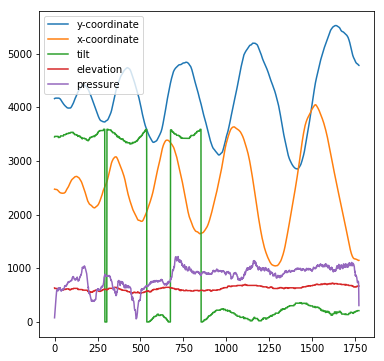

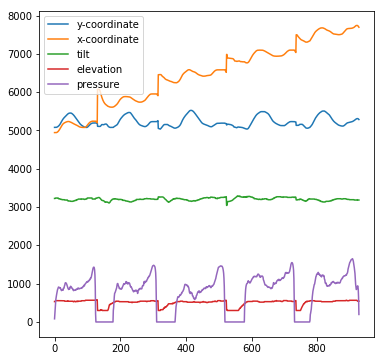

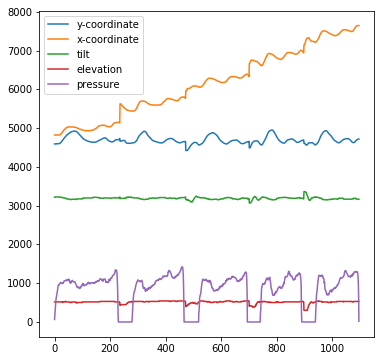

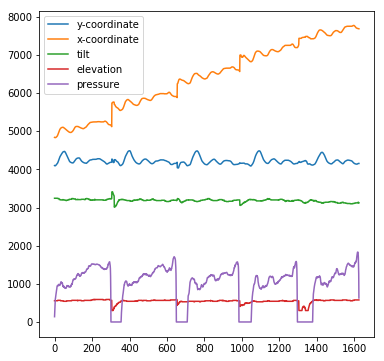

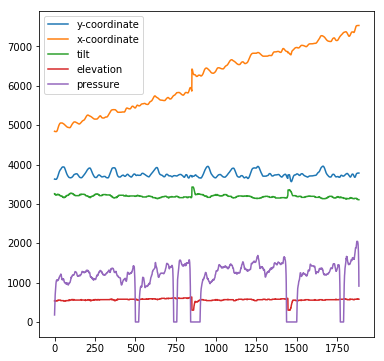

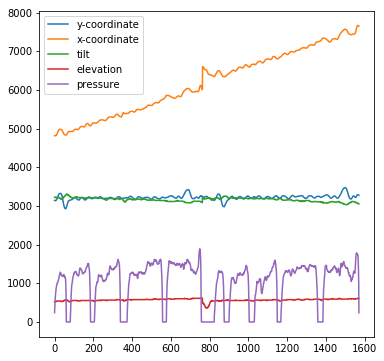

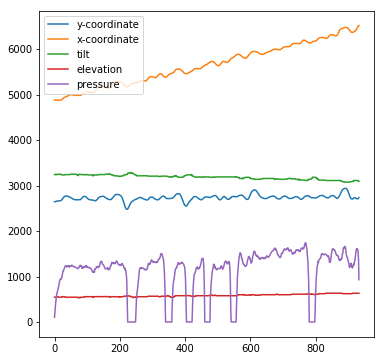

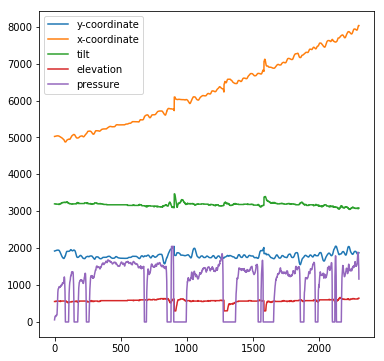

In [572]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
for j in range(8):
    print(index2task[j])
    task=np.asarray(raw[subject_index][j],dtype=int)
    if task.size!=0:
        plt.figure(figsize=(6,6))
        for i in [0,1,4,5,6]:
            plt.plot(task[:,i],label=index2measure[i])
            plt.legend()
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))
    

0
spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


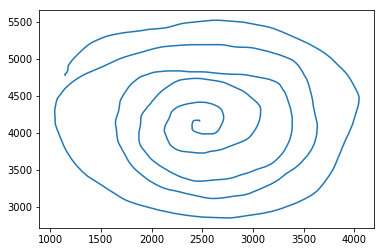

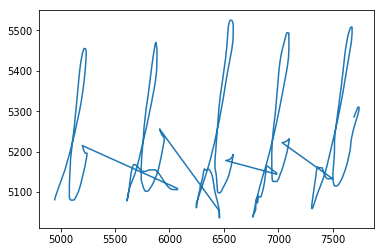

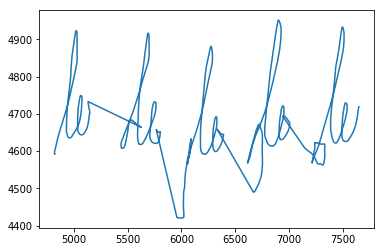

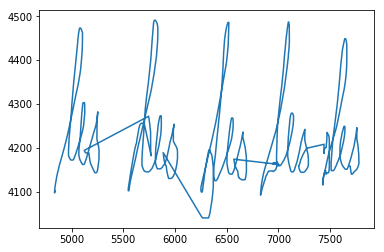

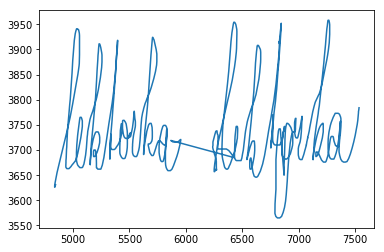

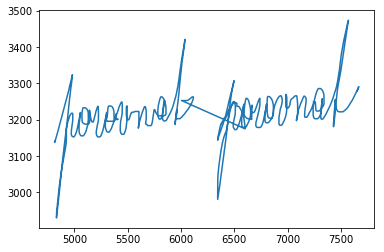

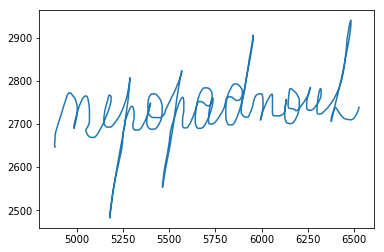

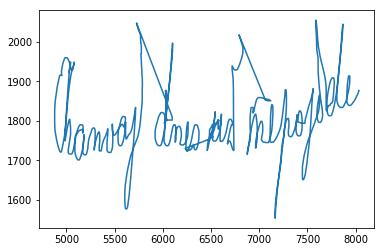

In [204]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
print(subject_index)
for j in range(8):
    print(index2task[j])
    task=np.asarray(raw[subject_index][j],dtype=int)
    if task.size!=0:
        plt.figure()
        plt.plot(task[:,1],task[:,0])
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))

## Preprocessing


### Standardize
along axis 0 in order to normalize all the measures independently (i.e. not all time steps independently)  
Cf. Report #4 : it's better to standardize than to normalize !

0
spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/

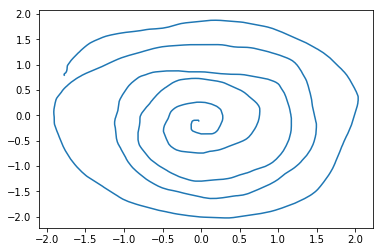

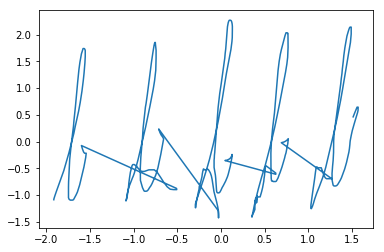

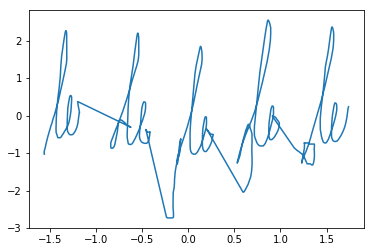

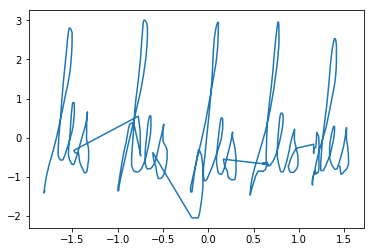

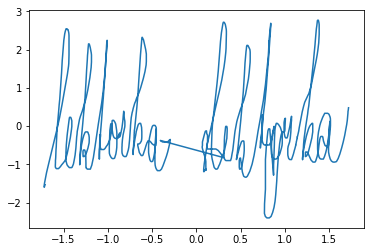

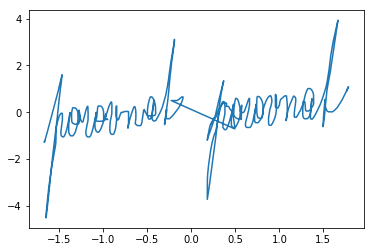

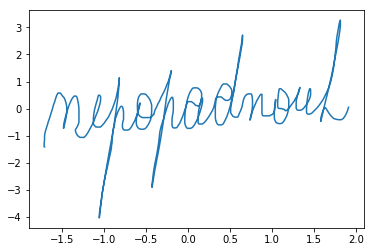

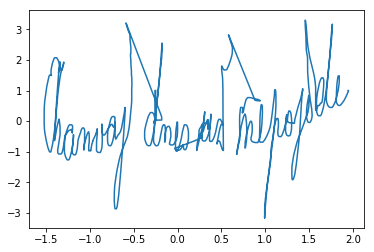

In [298]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
print(subject_index)
for j in range(8):
    print(index2task[j])
    task=scale(np.asarray(raw[subject_index][j],dtype=int),axis=0)
    if task.size!=0:
        plt.figure()
        plt.plot(task[:,1],task[:,0])
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))

## Spirals

In [12]:
spirals=[raw[i][0]  for i,subject in enumerate(raw) if len(raw[i][0])!=0]#discard the subjects that didn't perform spiral

In [13]:
spiral_targets= [labels[i]  for i,subject in enumerate(raw) if len(raw[i][0])!=0]
#for multi class #
#spiral_targets=[target[i]  for i,subject in enumerate(raw) if len(raw[i][0])!=0]
#discard the subjects that didn't perform spiral

the lengths of the spirals is extremely variable :  
mean, std :  
(2873.6944444444443, 2242.0327745578024)

In [15]:
for i,spiral in enumerate(spirals):
    spirals[i]=scale(np.asarray(spiral,dtype=int),axis=0)
print(len(spirals),len(spiral_targets))

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/

In [447]:
"""sparse_spiral=[measures for i,measures in enumerate(spirals[0]) if i%10 ==0]

%matplotlib inline
print(subject_index)
task=np.asarray(sparse_spiral)
plt.figure()
plt.plot(task[:,1],task[:,0])"""

### Data split
In order to provide for a meaningful comparison with works from Drotar et al. and Moetesum et al. we will evaluate our results using a 10-fold cross validation  
The actual split is done before [Training](#Training)

# Model
- [**Pytorch LSTM doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM)
- [**Pytorch Linear doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)
- [**Pytorch Binary Cross Entropy loss (BCELoss) doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)

## Definition
Cf. Report #4 for details about the architecture of the model

In [17]:
class Model(torch.nn.Module):
    """
    Args:
        #Vanilla LSTM
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
            would mean stacking two LSTMs together to form a `stacked LSTM`,
            with the second LSTM taking in outputs of the first LSTM and
            computing the final results. Default: 1
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False``
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
            LSTM layer except the last layer, with dropout probability equal to
            :attr:`dropout`. Default: 0
        bidirectional: If ``True``, becomes a bidirectional LSTM. Default: ``False``
        
        #our model
        batch_size : default : 1
        output_size : default : 2
    """
    def __init__(self, input_size, hidden_size,num_layers=1, bias=True,batch_first=False,
                 dropout=0,bidirectional=False, batch_size=1, output_size=2):
        super(Model, self).__init__()
        #Vanilla LSTM
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias=bias
        self.batch_first=batch_first
        self.dropout=dropout
        self.bidirectional=bidirectional
        #our model
        self.batch_size = batch_size
        self.output_size = output_size

        # Define the LSTM layer
        self.encoder = torch.nn.LSTM(self.input_size, self.hidden_size, self.num_layers,self.bias,self.batch_first,
                            self.dropout,self.bidirectional)

        # Define the decoder layer
        self.linear = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def init_hidden(self):
        """h_0 of shape (num_layers * num_directions, batch, hidden_size): 
        tensor containing the initial hidden state for each element in the batch. 
        If the RNN is bidirectional, num_directions should be 2, else it should be 1.

        c_0 of shape (num_layers * num_directions, batch, hidden_size): 
        tensor containing the initial cell state for each element in the batch.
        """
        num_directions=1
        if self.bidirectional:
            num_directions=2
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers*num_directions, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers*num_directions, self.batch_size, self.hidden_size))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of encoder_out: (seq_len, batch, num_directions * hidden_size)
        # shape of self.hidden: (h_n, c_n), where hidden state h_n and cell state c_n both 
        # have shape (num_layers * num_directions, batch, hidden_size).
        encoder_out, self.hidden = self.encoder(input)
        #print(encoder_out.shape)
        
        if self.bidirectional:
            #sums the outputs : direction left-right and direction right-left
            # encoder_out shape should now be (seq_len, batch,hidden_size)
            encoder_out = encoder_out[: ,: ,: self.hidden_size] + encoder_out[: , :, self.hidden_size: ]
        
        # Only take the output from the final timestep
        # Can pass on the entirety of encoder_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(encoder_out[-1])
        y_pred = self.sigmoid(y_pred)
        return y_pred.squeeze(0)
    
    def count_params(self):
        """returns (total n° of parameters, n° of trainable parameters)"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total_params, trainable_params


## Hyperparameters

In [19]:
learning_rate = 1e-4
hidden_size=100
num_layers=1
bidirectional=True
dropout=0.0
clip=5.0#clipping value to clip the gradients norm : set to None if you don't want to clip

input_size=7#==len(index2measure)
bias=True
batch_first=False#we should unsqueeze(1) to add a batch dimension
batch_size=1
output_size=1#binary classif : 1 means PD, 0 means control

loss_fn=torch.nn.BCELoss()#Binary cross entropy

# Training
## step

In [20]:
def step(input, target, model, optimizer, loss_fn, batch_size,clip=None,validation = False):
    if not validation:
        # Zero gradients
        optimizer.zero_grad()    
        
    # Set device options
    input=input.to(device)
    target=target.to(device)
        
    #forward pass
    output=model(input)
    
    # Compute loss
    loss = loss_fn(output, target)
    
    
    
    if not validation:
        # Perform backpropagation
        loss.backward()
        if clip is not None:
            #clip gradients to previent exploding
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        # Adjust model weights
        optimizer.step()
    
    return loss.item(), output.item()

## epoch

In [21]:
def epoch(data,targets, model, optimizer, loss_fn, batch_size, random_index,clip=None,validation=False):
    losses=[]
    predictions=[]
    condition_targets=[]
    
    for index in random_index:
        condition_targets.append(targets[index])
        #numpy to tensor
        subject=torch.Tensor(data[index]).unsqueeze(1)#add batch dimension
        target=torch.Tensor([targets[index]])        
        loss, prediction =step(subject,target, model, optimizer, loss_fn, batch_size,clip,validation)
        predictions.append(round(prediction))
        losses.append(loss)
    
    #compute metrics
    tn, fp, fn, tp = metrics.confusion_matrix(y_true=condition_targets,y_pred=predictions,labels=[0,1]).ravel()
    accuracy= (tp+tn)/(tp+tn+fp+fn)
    sensitivity = tp/(tp+fn) if (tp+fn) != 0 else 0.0 #without condition positives the sensitivity should be 0
    specificity = tn/(tn+fp) if (tn+fp)!= 0 else 0.0 #idem
    ppv = tp/(tp+fp) if tp+fp != 0 else 0.0 #without predicted positives the ppv should be 0
    npv = tn/(tn+fn) if tn+fn !=0 else 0.0 #idem
    
    return [np.mean(losses),accuracy,sensitivity,specificity,ppv,npv]

## 10 fold cross validation (early stopping)

In [ ]:
verbose=False
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(spirals, spiral_targets)
fold_train_metrics,fold_valid_metrics=[],[]
start = time()
np.random.seed(1)
save_to_print=""
fold=0
n_epochs=50#max n° of epochs the model will be trained to
patience = 5#n° of epochs without improvement where the model will wait before stopping

for train_index,test_index in cv_generator:     
    train_metrics,valid_metrics=[],[]
    model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                 dropout,bidirectional, batch_size, output_size)
    model.hidden=model.init_hidden()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    #best_accuracy=0
    best_loss=10000.0
    impatience=0
    for i in range(n_epochs):                
        to_print=""
        np.random.shuffle(train_index)
        np.random.shuffle(test_index)
        #training
        model.train()
        loss,accuracy,sensitivity,specificity,ppv,npv=epoch(
            spirals,spiral_targets, model, optimizer, loss_fn, batch_size, train_index,clip,validation=False)
        train_metrics_tmp=[loss,accuracy,sensitivity,specificity,ppv,npv]
        to_print+="\n\nfold n°{}, epoch n°{}, spent {}".format(fold,i,timeSince(start))
        to_print+="\nTRAINING : loss {:.3f}, accuracy {:.3f}".format(loss,accuracy)

        #validation
        model.eval()
        loss,accuracy,sensitivity,specificity,ppv,npv=epoch(
            spirals,spiral_targets, model, optimizer, loss_fn, batch_size, test_index,validation=True)  
        to_print+="\nVALIDATION : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
            loss,accuracy,sensitivity,specificity,ppv,npv)
        
        #patience update        
        if loss>=best_loss:#accuracy <= best_accuracy:#`<=` no improvement is considered bad !
            impatience+=1
        else:
            best_loss=loss#best_accuracy=accuracy 
            impatience=0
            
        train_metrics.append(train_metrics_tmp)
        valid_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        if verbose:
            print(to_print)
        save_to_print+=to_print
       
        #early stopping
        if impatience > patience:
            save_to_print+="\nEarly stopped."
            break     
            
    fold_train_metrics.append(train_metrics)
    fold_valid_metrics.append(valid_metrics)
    fold+=1
if not verbose:
    print(save_to_print)

## 1 over 10 fold training (no early stopping)

In [46]:
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(spirals, spiral_targets)

fold=0

In [52]:
verbose=False
train_metrics,valid_metrics=[],[]
train_index,test_index=next(cv_generator)
print(test_index)
print("fold n°",fold)
model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                 dropout,bidirectional, batch_size, output_size)
model.hidden=model.init_hidden()
model=model.to(device)
print("(total n° of parameters, n° of trainable parameters)\n",model.count_params())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
save_to_print=""
start = time()
np.random.seed(1)

fold+=1

[10 14 29 38 45 53 55 67]
fold n° 4
(total n° of parameters, n° of trainable parameters)
 (87301, 87301)


In [53]:
for i in range(10):  
    to_print=""
    np.random.shuffle(train_index)
    np.random.shuffle(test_index)
    #training
    model.train()
    loss,accuracy,sensitivity,specificity,ppv,npv=epoch(
        spirals,spiral_targets, model, optimizer, loss_fn, batch_size, train_index,clip,validation=False)
    train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
    to_print+="\n\nfold n°{}, epoch n°{}, spent {}".format(fold,i,timeSince(start))
    to_print+="\nTRAINING : loss {:.3f}, accuracy {:.3f}".format(loss,accuracy)
    
    #validation
    model.eval()
    loss,accuracy,sensitivity,specificity,ppv,npv=epoch(
        spirals,spiral_targets, model, optimizer, loss_fn, batch_size, test_index,validation=True)    
    valid_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
    to_print+="\nVALIDATION : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
        loss,accuracy,sensitivity,specificity,ppv,npv)
    
    if verbose:
        print(to_print)    
    save_to_print+=to_print
if not verbose:
    print(save_to_print)



fold n°5, epoch n°0, spent 0m 25s
TRAINING : loss 0.698, accuracy 0.391
VALIDATION : loss 0.690, accuracy 0.375, sensitivity  0.250, specificity 0.500, ppv 0.333, npv 0.400

fold n°5, epoch n°1, spent 0m 48s
TRAINING : loss 0.692, accuracy 0.484
VALIDATION : loss 0.687, accuracy 0.625, sensitivity  0.750, specificity 0.500, ppv 0.600, npv 0.667

fold n°5, epoch n°2, spent 1m 11s
TRAINING : loss 0.689, accuracy 0.500
VALIDATION : loss 0.683, accuracy 0.750, sensitivity  0.750, specificity 0.750, ppv 0.750, npv 0.750

fold n°5, epoch n°3, spent 1m 33s
TRAINING : loss 0.686, accuracy 0.594
VALIDATION : loss 0.680, accuracy 0.625, sensitivity  0.750, specificity 0.500, ppv 0.600, npv 0.667

fold n°5, epoch n°4, spent 1m 56s
TRAINING : loss 0.683, accuracy 0.609
VALIDATION : loss 0.676, accuracy 0.750, sensitivity  0.750, specificity 0.750, ppv 0.750, npv 0.750

fold n°5, epoch n°5, spent 2m 19s
TRAINING : loss 0.680, accuracy 0.625
VALIDATION : loss 0.672, accuracy 0.750, sensitivity  0.

## Debug

In [227]:
subject=torch.Tensor(spirals[61]).unsqueeze(1)#add batch dimension
target=torch.Tensor([spiral_targets[61]])



In [235]:
step(subject,target, model, optimizer, loss_fn, batch_size)

(0.1351873129606247, 0.12644775211811066)

# Evaluation

In [58]:
print("number of epochs before early stopping for each fold:\n",[len(fold) for fold in fold_valid_metrics])
longest_fold=np.argmax([len(fold) for fold in fold_valid_metrics])

number of epochs before early stopping for each fold:
 [3, 1, 2, 2, 1, 1, 1, 1, 2, 1]


In [25]:
def print_results(train_metrics,valid_metrics,early_stopping):
    train_metrics,valid_metrics=np.asarray(train_metrics),np.asarray(valid_metrics)
    print(learning_rate ,"|",hidden_size,"|",num_layers,"|",bidirectional,"|",dropout,"|",clip,"|","{:.2f} (+ {:.2f}) | {:.2f} (+ {:.2f}) ".format(
    np.mean(early_stopping),np.std(early_stopping),np.mean(train_metrics[:,1]),np.std(train_metrics[:,1])),end="")
    
    valid_metrics=valid_metrics.T
    for metric in valid_metrics[1:]:#don't care about the loss
        mean,std=np.mean(metric),np.std(metric)
        print("| {:.2f} (+ {:.2f}) ".format(mean,std),end="")


In [59]:
"""fold[-1] is the last epoch of the fold, so the best one according to the validation accuracy"""
try:
    assert np.max([len(fold) for fold in fold_valid_metrics]) < n_epochs
except AssertionError:
    print("The model didn't early stop therefore fold[-patience] is not the best epoch")
else:
    print_results([fold[-1] for fold in fold_train_metrics],[fold[-1] for fold in fold_valid_metrics],[len(fold) for fold in fold_valid_metrics])

0.0001 | 100 | 1 | True | 0.0 | 5.0 | 1.50 (+ 0.67) | 0.54 (+ 0.04) | 0.65 (+ 0.13) | 0.55 (+ 0.27) | 0.75 (+ 0.18) | 0.68 (+ 0.29) | 0.65 (+ 0.14) 

## 10 fold cross validation with early stopping
/!\ validating on the test set /!\  
Average metric over the 10 folds + standard deviation (i.e. we select the best epoch based on the validation accuracy for each fold)  
early stopped : n° of epochs + std  
Every metric is for the validation set if not specified otherwise  
The changing hyperparameters are print in **bold**.  
Note : 
- the max epochs was set at 5 for the first 2 lines, 10 for the 3rd and 4rd lines and 50 for the rest 
- there was no patience for early stopping for the first 7 lines  

 
 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
0.001 | 100 | 1 | False | 0.0 | **None** | 2.70 (+ 1.42) | 0.59 (+ 0.07) | 0.68 (+ 0.09) | 0.54 (+ 0.20) | 0.82 (+ 0.20) | 0.81 (+ 0.20) | 0.65 (+ 0.08) 
0.001 | 100 | 1 | False | 0.0 | **50.0** | 2.30 (+ 1.49) | 0.58 (+ 0.07) | 0.68 (+ 0.10) | 0.58 (+ 0.17) | 0.78 (+ 0.16) | 0.75 (+ 0.17) | 0.66 (+ 0.09) 
0.001 | 100 | 1 | False | 0.0 | **5.0** | 3.80 (+ 2.86) | 0.59 (+ 0.04) | 0.65 (+ 0.10) | 0.58 (+ 0.17) | 0.72 (+ 0.16) | 0.70 (+ 0.17) | 0.64 (+ 0.09)
0.001 | 100 | 1 | **True** | 0.0 | 5.0 | 3.80 (+ 2.04) | 0.60 (+ 0.07) | 0.67 (+ 0.09) | 0.58 (+ 0.28) | 0.75 (+ 0.26) | 0.78 (+ 0.19) | 0.71 (+ 0.17) 
**0.01** | 100 | 1 | True | 0.0 | 5.0 | 4.30 (+ 5.98) | 0.55 (+ 0.10) | 0.64 (+ 0.08) | 0.57 (+ 0.24) | 0.71 (+ 0.26) | 0.75 (+ 0.21) | 0.67 (+ 0.17) 
**0.1** | 100 | 1 | True | 0.0 | 5.0 | 19.33 (+ 21.75) | 0.48 (+ 0.03) | 0.58 (+ 0.12) | 1.00 (+ 0.00) | 0.17 (+ 0.24) | 0.56 (+ 0.08) | 0.33 (+ 0.47) 
**0.0001** | 100 | 1 | True | 0.0 | 5.0 | 14.80 (+ 12.37) | 0.63 (+ 0.09) | 0.71 (+ 0.09) | 0.55 (+ 0.27) | 0.87 (+ 0.18) | 0.88 (+ 0.15) | 0.70 (+ 0.16) 
0.0001 | 100 | 1 | True | 0.0 | 5.0 | 1.50 (+ 0.67) | 0.54 (+ 0.04) | 0.65 (+ 0.13) | 0.55 (+ 0.27) | 0.75 (+ 0.18) | 0.68 (+ 0.29) | 0.65 (+ 0.14) 

In [34]:
"""fold[-1] is the last epoch of the fold, so the best one according to the validation accuracy"""
print_results([fold_train_metrics[i][13] for i in [0,1,6,7,8,9]],[fold_valid_metrics[i][13] for i in [0,1,6,7,8,9]],[len(fold_train_metrics[i]) for i in [0,1,6,7,8,9]])

0.0001 | 100 | 1 | True | 0.0 | 5.0 | 23.50 (+ 8.08) | 0.64 (+ 0.03) | 0.67 (+ 0.04) | 0.54 (+ 0.26) | 0.81 (+ 0.20) | 0.83 (+ 0.17) | 0.68 (+ 0.15) 

### Results for folds with late stop

These results are less optimistic as we empirically select the folds which stopped after 10 epochs and use the same epoch to evaluate all the folds. We chose this number as the earliest stop among the selected folds  

 n° of folds |learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--|--
6|0.0001 | 100 | 1 | True | 0.0 | 5.0 | 23.50 (+ 8.08) | 0.64 (+ 0.03) | 0.67 (+ 0.04) | 0.54 (+ 0.26) | 0.81 (+ 0.20) | 0.83 (+ 0.17) | 0.68 (+ 0.15) 

## 5 fold cross validation with early stopping
/!\ validating on the test set /!\  
Average metric over the 5 folds + standard deviation (i.e. we select the best epoch based on the validation accuracy for each fold)  
Every metric is for the validation set if not specified otherwise 

 learning_rate |hidden_size|num_layers|bidirectional|dropout|TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--
0.001 | 100 | 1 | False | 0.0 | 0.62 (+ 0.04) | 0.60 (+ 0.05) | 0.63 (+ 0.27) | 0.56 (+ 0.35) | 0.68 (+ 0.18) | 0.50 (+ 0.26) 

## 10 fold cross validation with 1 epoch per fold

 learning_rate |hidden_size|num_layers|bidirectional|dropout|train accuracy | valid accuracy 
--|--|--|--|--|--|--
0.001 | 100 | 2 | True | 0.0 | 0.508 (+ 0.044) | 0.571 (+ 0.107) 

# Visualization

In [343]:
np.asarray(fold_train_metrics).shape

(10, 5, 6)

In [40]:
avg_train=np.mean([fold_train_metrics[i][0:14] for i in [0,1,6,7,8,9]],axis=0)#np.mean(np.asarray(fold_train_metrics),axis=0)
avg_valid=np.mean([fold_valid_metrics[i][0:14] for i in [0,1,6,7,8,9]],axis=0)#np.mean(np.asarray(fold_valid_metrics),axis=0)

## Loss

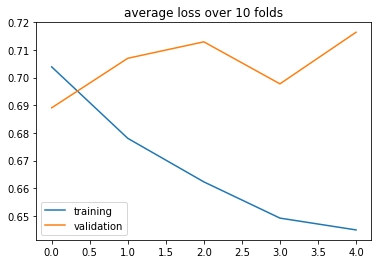

In [347]:
plt.figure()
plt.title("average loss over 10 folds")
plt.plot(avg_train[:,0],label="training")
plt.plot(avg_valid[:,0],label="validation")
plt.legend()

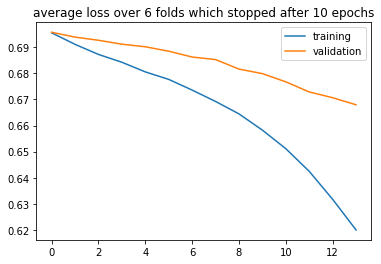

In [41]:
plt.figure()
plt.title("average loss over 6 folds which stopped after 10 epochs")
plt.plot(avg_train[:,0],label="training")
plt.plot(avg_valid[:,0],label="validation")
plt.legend()

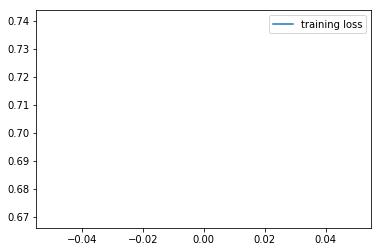

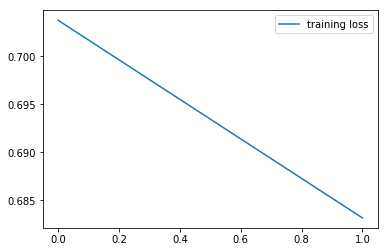

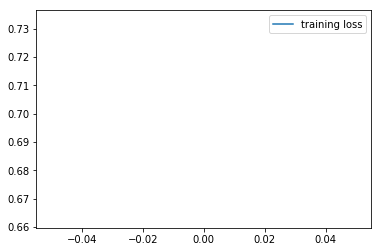

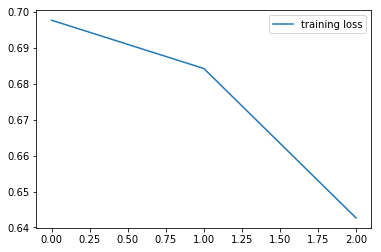

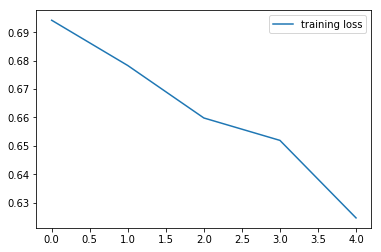

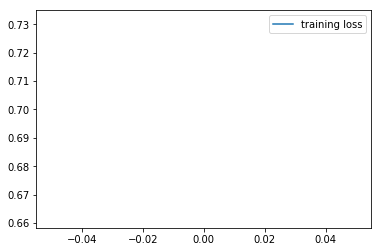

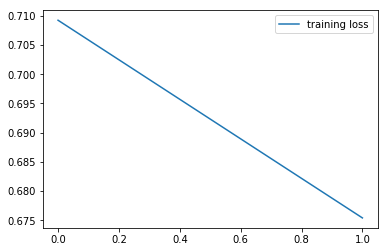

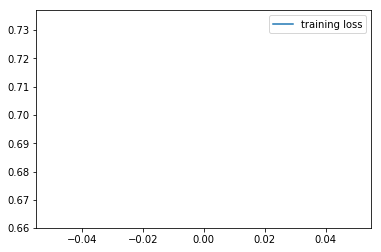

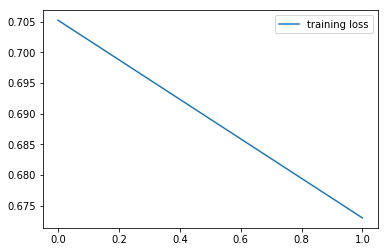

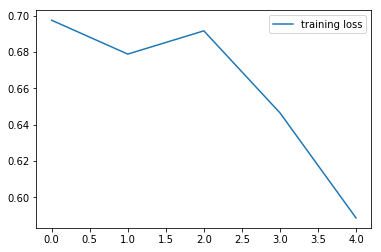

In [595]:
for train_metrics in fold_train_metrics:
    plt.figure()
    plt.plot(np.asarray(train_metrics)[:,0],label="training loss")
    plt.legend()

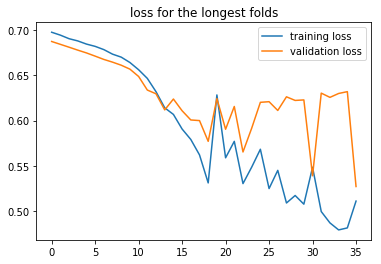

In [35]:
plt.figure()
plt.title("loss for the longest folds")
plt.plot(np.asarray(fold_train_metrics[longest_fold])[:,0],label="training loss")
plt.plot(np.asarray(fold_valid_metrics[longest_fold])[:,0],label="validation loss")
plt.legend()

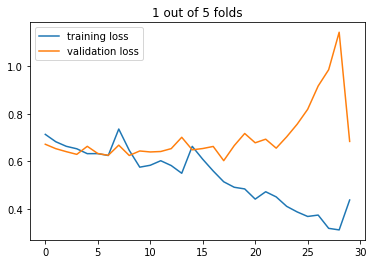

In [460]:
plt.figure()
plt.title("1 out of 5 folds")
plt.plot(np.asarray(train_metrics)[:,0],label="training loss")
plt.plot(np.asarray(valid_metrics)[:,0],label="validation loss")
plt.legend()

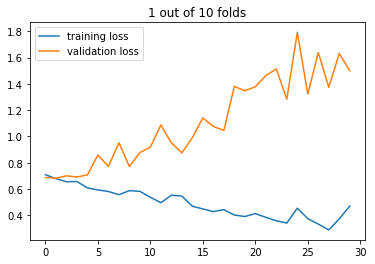

In [558]:
plt.figure()
plt.title("easy fold : 1 out of 10 folds")
plt.plot(np.asarray(train_metrics)[:,0],label="training loss")
plt.plot(np.asarray(valid_metrics)[:,0],label="validation loss")
plt.legend()

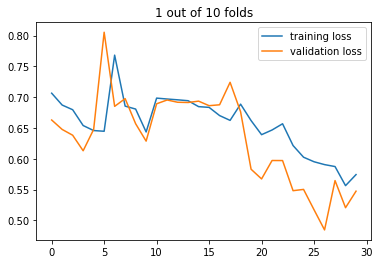

In [547]:
plt.figure()
plt.title("hard fold : without gradient clipping : 1 out of 10 folds")
plt.plot(np.asarray(train_metrics)[:,0],label="training loss")
plt.plot(np.asarray(valid_metrics)[:,0],label="validation loss")
plt.legend()

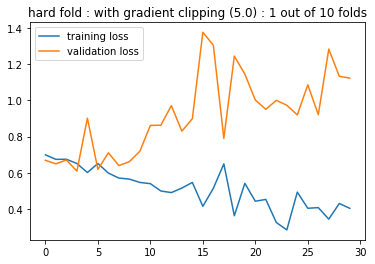

In [634]:
plt.figure()
plt.title("hard fold : with gradient clipping (5.0) : 1 out of 10 folds")
plt.plot(np.asarray(train_metrics)[:,0],label="training loss")
plt.plot(np.asarray(valid_metrics)[:,0],label="validation loss")
plt.legend()

## Accuracy

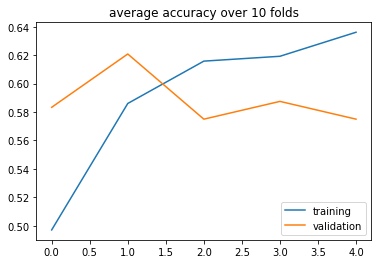

In [341]:
plt.figure()
plt.title("average accuracy over 10 folds")
plt.plot(avg_train[:,1],label="training")
plt.plot(avg_valid[:,1],label="validation")
plt.legend()

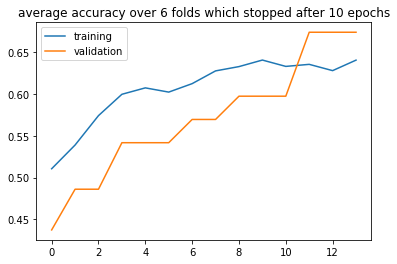

In [42]:
plt.figure()
plt.title("average accuracy over 6 folds which stopped after 10 epochs")

plt.plot(avg_train[:,1],label="training")
plt.plot(avg_valid[:,1],label="validation")
plt.legend()

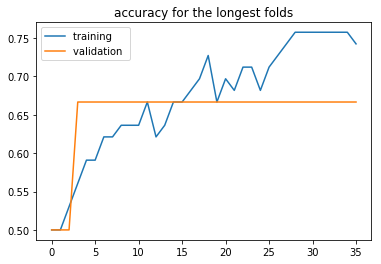

In [36]:
plt.figure()
plt.title("accuracy for the longest folds")
plt.plot(np.asarray(fold_train_metrics[longest_fold])[:,1],label="training ")
plt.plot(np.asarray(fold_valid_metrics[longest_fold])[:,1],label="validation ")
plt.legend()

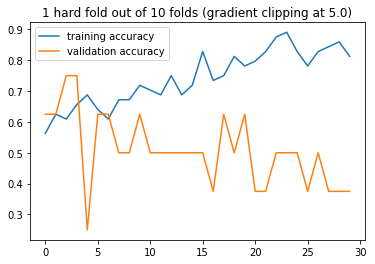

In [635]:
plt.figure()

plt.title("1 hard fold out of 10 folds (gradient clipping at 5.0)")
plt.plot(np.asarray(train_metrics)[:,1],label="training accuracy")
plt.plot(np.asarray(valid_metrics)[:,1],label="validation accuracy")
plt.legend()

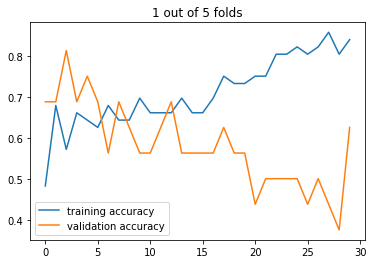

In [461]:
plt.figure()

plt.title("1 out of 5 folds")
plt.plot(np.asarray(train_metrics)[:,1],label="training accuracy")
plt.plot(np.asarray(valid_metrics)[:,1],label="validation accuracy")
plt.legend()

## Model weights

In [596]:
fold_train_metrics[0]

[[0.7049412904307246, 0.53125, 0.1875, 0.875, 0.6, 0.5185185185185185]]

In [533]:
generator = model.modules()
print(next(generator))
lstm=next(generator)

Model(
  (encoder): LSTM(7, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [539]:
print("""the learnable input-hidden weights of the kth layer (W_ii|W_if|W_ig|W_io) (with k=0 in our case),
of shape (4*hidden_size x input_size)""")
print(lstm.weight_ih_l0.shape)
input_weights=lstm.weight_ih_l0.cpu().detach().numpy()

the learnable input-hidden weights of the kth layer (W_ii|W_if|W_ig|W_io) (with k=0 in our case),
of shape (4*hidden_size x input_size)
torch.Size([400, 7])
